In [9]:
from kubernetes import client, config

# Define the list of resources you want to retrieve (modifiable)
resource_list = ['cpu', 'memory', 'nvidia.com/gpu']

# Load kubeconfig
config.load_kube_config()

# Create an API client
v1 = client.CoreV1Api()

# Get all nodes in the cluster
nodes = v1.list_node()

# Iterate over nodes to get resource capacity based on the resource_list
for node in nodes.items:
    node_name = node.metadata.name
    print(f"Node: {node_name}")

    for resource in resource_list:
        # Check if the resource exists in node capacity, and print it
        if resource in node.status.capacity:
            resource_capacity = node.status.capacity[resource]
            print(f"{resource.capitalize()} Capacity: {resource_capacity}")
        else:
            print(f"{resource.capitalize()} Capacity: Not available")

    print()  # Newline for better readability between nodes


Node: k8s-master
Cpu Capacity: 32
Memory Capacity: 131897852Ki
Nvidia.com/gpu Capacity: Not available

Node: k8s-worker-1
Cpu Capacity: 4
Memory Capacity: 16373244Ki
Nvidia.com/gpu Capacity: Not available

Node: k8s-worker-2
Cpu Capacity: 4
Memory Capacity: 16373256Ki
Nvidia.com/gpu Capacity: Not available

Node: k8s-worker-3
Cpu Capacity: 4
Memory Capacity: 16373256Ki
Nvidia.com/gpu Capacity: Not available

Node: k8s-worker-4
Cpu Capacity: 4
Memory Capacity: 16373256Ki
Nvidia.com/gpu Capacity: Not available

Node: k8s-worker-5
Cpu Capacity: 4
Memory Capacity: 16373256Ki
Nvidia.com/gpu Capacity: Not available

Node: k8s-worker-6
Cpu Capacity: 4
Memory Capacity: 16373256Ki
Nvidia.com/gpu Capacity: Not available

Node: k8s-worker-7
Cpu Capacity: 4
Memory Capacity: 16373256Ki
Nvidia.com/gpu Capacity: Not available

Node: k8s-worker-8
Cpu Capacity: 4
Memory Capacity: 16373256Ki
Nvidia.com/gpu Capacity: Not available

Node: k8s-worker-9
Cpu Capacity: 4
Memory Capacity: 16373256Ki
Nvidia.com

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import multiprocessing as mp
from timeit import default_timer as timer

# Dummy function for transmitted_req_calculator for demonstration purposes
def transmitted_req_calculator(workload_src, workload_dst, timerange, step_interval):
    return np.random.randint(1, 20)

# Example list of deployments (replace with actual deployment names)
ready_deployments = ['dep1', 'dep2', 'dep3']

# Initialize an empty DataFrame
df = pd.DataFrame(index=ready_deployments, columns=ready_deployments, data=0.0)

# Fill the DataFrame with average request values
for deployment_src in ready_deployments:
    for deployment_dst in ready_deployments:
        if deployment_src != deployment_dst:  # Skip self to self comparison
            average_requests = transmitted_req_calculator(
                workload_src=deployment_src, 
                workload_dst=deployment_dst, 
                timerange=120, 
                step_interval='5m'
            )
            df.at[deployment_src, deployment_dst] = average_requests

# Plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df, cmap='viridis', annot=True)
plt.title('Average Requests per 5 Minutes among Pods')
plt.xlabel('Destination Pods')
plt.ylabel('Source Pods')
plt.show()

# Convert DataFrame to exec_graph (numpy array)
exec_graph = df.to_numpy()

# Function to calculate the communication cost with resource constraint checks
def calculate_communication_cost(exec_graph, placement, delay_matrix, resource_demand, server_capacities, penalty_factor=10):
    """
    Calculate the total communication cost while enforcing resource capacity constraints.

    Args:
        exec_graph: Traffic volume between microservices.
        placement: Current mapping of microservices to servers.
        delay_matrix: Delay between different servers.
        resource_demand: Resources required by each microservice.
        server_capacities: Available capacity of each server.
        penalty_factor: Penalty factor for exceeding server capacity.
    
    Returns:
        Total cost including any penalties for overloading servers.
    """
    cost = 0
    server_loads = [0] * len(server_capacities)  # Track the load on each server
    
    # Calculate the communication cost between microservices
    for u in range(len(exec_graph)):
        for v in range(len(exec_graph[u])):
            if exec_graph[u][v] > 0:
                server_u = placement[u]
                server_v = placement[v]
                cost += exec_graph[u][v] * delay_matrix[server_u][server_v]
    
    # Calculate the server loads based on the placement
    for u in range(len(placement)):
        server_loads[placement[u]] += resource_demand[u]
    
    # Penalize any server that exceeds its capacity
    penalty = 0
    for j in range(len(server_loads)):
        if server_loads[j] > server_capacities[j]:
            penalty += (server_loads[j] - server_capacities[j]) * penalty_factor  # Penalty for overloading
    
    return cost + penalty

# Sort microservice pairs by traffic volume (for granular parallelism)
def sort_microservice_pairs(exec_graph):
    """
    Sort the microservice pairs by traffic volume in descending order.
    
    Args:
        exec_graph: Traffic volume matrix between microservices.
    
    Returns:
        A sorted list of microservice pairs by traffic volume.
    """
    pairs = []
    for u in range(len(exec_graph)):
        for v in range(len(exec_graph[u])):
            if exec_graph[u][v] > 0:
                pairs.append((u, v, exec_graph[u][v]))  # (source, destination, traffic volume)
    # Sort pairs by traffic volume in descending order
    pairs.sort(key=lambda x: -x[2])
    return pairs

# Divide sorted microservice pairs into chunks for parallel processing
def divide_pairs_into_chunks(pairs, num_workers):
    """
    Divide the sorted pairs into chunks for parallel processing.
    
    Args:
        pairs: List of sorted microservice pairs by traffic volume.
        num_workers: Number of worker processes.
    
    Returns:
        A list of chunks of microservice pairs.
    """
    chunk_size = (len(pairs) + num_workers - 1) // num_workers
    chunks = [pairs[i * chunk_size: (i + 1) * chunk_size] for i in range(num_workers)]
    return chunks

# Worker function for greedy placement that accounts for capacity constraints
def greedy_placement_worker(exec_graph, delay_matrix, placement, num_servers, resource_demand, server_capacities, pairs_chunk):
    """
    Greedy placement algorithm that attempts to minimize communication cost
    while enforcing resource capacity constraints on servers.

    Args:
        exec_graph: Traffic volume between microservices.
        delay_matrix: Delay between different servers.
        placement: Current mapping of microservices to servers.
        num_servers: Total number of available servers.
        resource_demand: Resource demands of each microservice.
        server_capacities: Available capacity of each server.
        pairs_chunk: Subset of microservice pairs to process.
    
    Returns:
        Updated placement and corresponding cost.
    """
    current_cost = calculate_communication_cost(exec_graph, placement, delay_matrix, resource_demand, server_capacities)
    improved = True
    while improved:
        improved = False
        for u, v, _ in pairs_chunk:
            current_server_u = placement[u]
            current_server_v = placement[v]
            for new_server_u in range(num_servers):
                for new_server_v in range(num_servers):
                    if new_server_u != current_server_u or new_server_v != current_server_v:
                        new_placement = placement.copy()
                        new_placement[u] = new_server_u
                        new_placement[v] = new_server_v
                        
                        # Ensure new placement doesn't violate server capacity
                        new_cost = calculate_communication_cost(exec_graph, new_placement, delay_matrix, resource_demand, server_capacities)
                        if new_cost < current_cost:
                            placement = new_placement
                            current_cost = new_cost
                            improved = True
                            break
                if improved:
                    break
            if improved:
                break
    return placement, current_cost

# Parallel greedy placement function with capacity constraints and granular parallelism
def parallel_greedy_placement(exec_graph, delay_matrix, placement, num_servers, resource_demand, server_capacities, num_workers=4):
    """
    Parallel greedy placement algorithm that attempts to minimize communication cost
    while enforcing server capacity constraints and utilizing granular parallelism.

    Args:
        exec_graph: Traffic volume between microservices.
        delay_matrix: Delay between different servers.
        placement: Current mapping of microservices to servers.
        num_servers: Total number of available servers.
        resource_demand: Resource demands of each microservice.
        server_capacities: Available capacity of each server.
        num_workers: Number of parallel worker processes.
    
    Returns:
        Final optimal placement and corresponding total cost.
    """
    # Step 1: Sort microservice pairs by traffic volume
    sorted_pairs = sort_microservice_pairs(exec_graph)
    
    # Step 2: Divide sorted pairs into chunks for parallel processing
    chunks = divide_pairs_into_chunks(sorted_pairs, num_workers)
    
    while True:
        pool = mp.Pool(num_workers)
        tasks = [(exec_graph, delay_matrix, placement, num_servers, resource_demand, server_capacities, chunk) for chunk in chunks]
        results = pool.starmap(greedy_placement_worker, tasks)
        pool.close()
        pool.join()

        new_placement = results[0][0]
        new_cost = results[0][1]
        improved = False

        for result in results[1:]:
            if result[1] < new_cost:
                new_placement = result[0]
                new_cost = result[1]
                improved = True

        if not improved:
            break

        placement = new_placement

    return placement, new_cost

# Example usage with randomly generated delay matrix, resource demands, and server capacities
M = len(exec_graph)  # Number of microservices
N = 5  # Number of servers (adjust as needed)
delay_matrix = np.random.randint(1, 11, size=(N, N))  # Generate an N*N matrix with values between 1 and 10
np.fill_diagonal(delay_matrix, 0)  # Set the diagonal elements to zero

# Generate random resource demands for each microservice
resource_demand = np.random.randint(1, 6, size=M)  # Each microservice requires between 1 and 5 units of resource

# Generate random capacities for each server
server_capacities = np.random.randint(10, 20, size=N)  # Each server can handle between 10 and 20 units of resource

# Initial random placement
initial_placement = [random.randint(0, N - 1) for _ in range(M)]
initial_cost = calculate_communication_cost(exec_graph, initial_placement, delay_matrix, resource_demand, server_capacities)

# Perform parallel greedy placement with capacity constraints
final_placement, total_cost = parallel_greedy_placement(exec_graph, delay_matrix, initial_placement, N, resource_demand, server_capacities, num_workers=mp.cpu_count())

print("Initial Placement:", initial_placement)
print("Initial Cost:", initial_cost)
print("Final Placement:", final_placement)
print("Total Communication Cost:", total_cost)


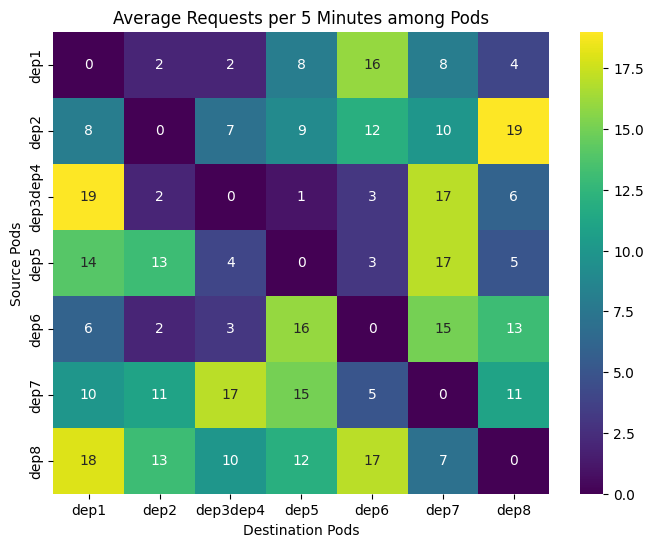

Number of chunks: 32
chunks= [[(1, 6, 19.0), (2, 0, 19.0)], [(6, 0, 18.0), (2, 5, 17.0)], [(3, 5, 17.0), (5, 2, 17.0)], [(6, 4, 17.0), (0, 4, 16.0)], [(4, 3, 16.0), (4, 5, 15.0)], [(5, 3, 15.0), (3, 0, 14.0)], [(3, 1, 13.0), (4, 6, 13.0)], [(6, 1, 13.0), (1, 4, 12.0)], [(6, 3, 12.0), (5, 1, 11.0)], [(5, 6, 11.0), (1, 5, 10.0)], [(5, 0, 10.0), (6, 2, 10.0)], [(1, 3, 9.0), (0, 3, 8.0)], [(0, 5, 8.0), (1, 0, 8.0)], [(1, 2, 7.0), (6, 5, 7.0)], [(2, 6, 6.0), (4, 0, 6.0)], [(3, 6, 5.0), (5, 4, 5.0)], [(0, 6, 4.0), (3, 2, 4.0)], [(2, 4, 3.0), (3, 4, 3.0)], [(4, 2, 3.0), (0, 1, 2.0)], [(0, 2, 2.0), (2, 1, 2.0)], [(4, 1, 2.0), (2, 3, 1.0)], [], [], [], [], [], [], [], [], [], [], []] 

Initial Placement: [0, 1, 4, 0, 4, 0, 3]
Initial Cost: 1340.0
Final Placement: [0, 1, 0, 0, 0, 0, 0]
Total Communication Cost: 0.0


In [7]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import multiprocessing as mp
from timeit import default_timer as timer

# Dummy function for transmitted_req_calculator for demonstration purposes
def transmitted_req_calculator(workload_src, workload_dst, timerange, step_interval):
    return np.random.randint(1,20)

# Example list of deployments (replace with actual deployment names)
ready_deployments = ['dep1', 'dep2', 'dep3' 'dep4', 'dep5','dep6', 'dep7', 'dep8']#, 'dep9', 'dep10', 'dep11', 'dep12', 'dep13', 'dep14', 'dep15','dep16', 'dep17', 'dep18', 'dep19', 'dep20']

# Initialize an empty DataFrame
df = pd.DataFrame(index=ready_deployments, columns=ready_deployments, data=0.0)

# Fill the DataFrame with average request values
for deployment_src in ready_deployments:
    for deployment_dst in ready_deployments:
        if deployment_src != deployment_dst:  # Skip self to self comparison
            average_requests = transmitted_req_calculator(
                workload_src=deployment_src, 
                workload_dst=deployment_dst, 
                timerange=120, 
                step_interval='5m'
            )
            df.at[deployment_src, deployment_dst] = average_requests

# Plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df, cmap='viridis', annot= True)
plt.title('Average Requests per 5 Minutes among Pods')
plt.xlabel('Destination Pods')
plt.ylabel('Source Pods')
plt.show()

# Convert DataFrame to exec_graph (numpy array)
exec_graph = df.to_numpy()

# Define the functions for placement and cost calculation
def calculate_communication_cost(exec_graph, placement, delay_matrix):
    cost = 0
    for u in range(len(exec_graph)):
        for v in range(len(exec_graph[u])):
            if exec_graph[u][v] > 0:
                server_u = placement[u]
                server_v = placement[v]
                cost += exec_graph[u][v] * delay_matrix[server_u][server_v]
    return cost

# Sort microservice pairs by traffic volume (Step 1)
def sort_microservice_pairs(exec_graph):
    pairs = []
    for u in range(len(exec_graph)):
        for v in range(len(exec_graph[u])):
            if exec_graph[u][v] > 0:
                pairs.append((u, v, exec_graph[u][v]))  # (source, destination, traffic volume)
    # Sort pairs by traffic volume in descending order
    pairs.sort(key=lambda x: -x[2])
    return pairs

# Granular division of high-traffic pairs into chunks (Step 2)
def divide_pairs_into_chunks(pairs, num_workers):
    chunk_size = (len(pairs) + num_workers - 1) // num_workers
    chunks = [pairs[i * chunk_size: (i + 1) * chunk_size] for i in range(num_workers)]

    return chunks

# Worker function that optimizes placement based on the chunk of high-traffic pairs
def greedy_placement_worker(exec_graph, delay_matrix, placement, num_servers, pairs_chunk):
    current_cost = calculate_communication_cost(exec_graph, placement, delay_matrix)
    improved = True
    while improved:
        improved = False
        for u, v, _ in pairs_chunk:
            current_server_u = placement[u]
            current_server_v = placement[v]
            for new_server_u in range(num_servers):
                for new_server_v in range(num_servers):
                    if new_server_u != current_server_u or new_server_v != current_server_v:
                        new_placement = placement.copy()
                        new_placement[u] = new_server_u
                        new_placement[v] = new_server_v
                        new_cost = calculate_communication_cost(exec_graph, new_placement, delay_matrix)
                        if new_cost < current_cost:
                            placement = new_placement
                            current_cost = new_cost
                            improved = True
                            break
                if improved:
                    break
            if improved:
                break
    return placement, current_cost

# Modified parallel placement function with granular parallelism (Step 3)
def parallel_greedy_placement(exec_graph, delay_matrix, placement, num_servers, num_workers=4):
    # Step 1: Sort microservice pairs by traffic volume
    sorted_pairs = sort_microservice_pairs(exec_graph)
    
    # Step 2: Divide sorted pairs into chunks
    chunks = divide_pairs_into_chunks(sorted_pairs, num_workers)
    print("Number of chunks:", len(chunks))
    print("chunks=", chunks, "\n")
    
    while True:
        
        pool = mp.Pool(num_workers)
        tasks = [(exec_graph, delay_matrix, placement, num_servers, chunk) for chunk in chunks]
        results = pool.starmap(greedy_placement_worker, tasks)
        pool.close()
        pool.join()

        new_placement = results[0][0]
        new_cost = results[0][1]
        improved = False

        for result in results[1:]:
            if result[1] < new_cost:
                new_placement = result[0]
                new_cost = result[1]
                improved = True

        if not improved:
            break

        placement = new_placement

    return placement, new_cost

# Example usage with randomly generated delay matrix and initial placement
M = len(exec_graph)  # Number of microservices
N = 5  # Number of servers (adjust as needed)
delay_matrix = np.random.randint(1, 11, size=(N, N))  # Generate an N*N matrix with values between 1 and 10
np.fill_diagonal(delay_matrix, 0)  # Set the diagonal elements to zero

# Initial random placement
initial_placement = [random.randint(0, N - 1) for _ in range(M)]
initial_cost = calculate_communication_cost(exec_graph, initial_placement, delay_matrix)

# Perform parallel greedy placement with granular parallelism
final_placement, total_cost = parallel_greedy_placement(exec_graph, delay_matrix, initial_placement, N, num_workers=mp.cpu_count())

print("Initial Placement:", initial_placement)
print("Initial Cost:", initial_cost)
print("Final Placement:", final_placement)
print("Total Communication Cost:", total_cost)


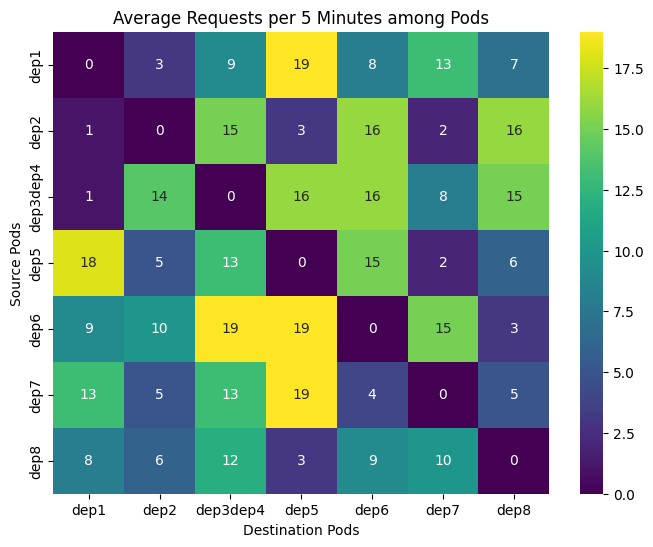

1 = (7 + 32 - 1) // 32
lengnths of results: 32
Results: [([1, 2, 1, 0, 3, 1, 1], 2051.0), ([4, 1, 1, 0, 3, 1, 1], 1840.0), ([4, 2, 0, 0, 3, 1, 1], 2161.0), ([4, 2, 1, 1, 3, 1, 1], 2150.0), ([4, 2, 1, 0, 1, 1, 1], 1871.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1, 1], 2343.0), ([4, 2, 1, 0, 3, 1,

In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import multiprocessing as mp
from timeit import default_timer as timer

# Dummy function for transmitted_req_calculator for demonstration purposes
def transmitted_req_calculator(workload_src, workload_dst, timerange, step_interval):
    return np.random.randint(1,20)

# Example list of deployments (replace with actual deployment names)
ready_deployments = ['dep1', 'dep2', 'dep3' 'dep4', 'dep5','dep6', 'dep7', 'dep8']#, 'dep9', 'dep10', 'dep11', 'dep12', 'dep13', 'dep14', 'dep15','dep16', 'dep17', 'dep18', 'dep19', 'dep20']

# Initialize an empty DataFrame
df = pd.DataFrame(index=ready_deployments, columns=ready_deployments, data=0.0)

# Fill the DataFrame with average request values
for deployment_src in ready_deployments:
    for deployment_dst in ready_deployments:
        if deployment_src != deployment_dst:  # Skip self to self comparison
            average_requests = transmitted_req_calculator(
                workload_src=deployment_src, 
                workload_dst=deployment_dst, 
                timerange=120, 
                step_interval='5m'
            )
            df.at[deployment_src, deployment_dst] = average_requests

# Plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df, cmap='viridis', annot= True)
plt.title('Average Requests per 5 Minutes among Pods')
plt.xlabel('Destination Pods')
plt.ylabel('Source Pods')
plt.show()

# Convert DataFrame to exec_graph (numpy array)
exec_graph = df.to_numpy()

# Define the functions for placement and cost calculation
def calculate_communication_cost(exec_graph, placement, delay_matrix):
    cost = 0
    for u in range(len(exec_graph)):
        for v in range(len(exec_graph[u])):
            if exec_graph[u][v] > 0:
                server_u = placement[u]
                server_v = placement[v]
                cost += exec_graph[u][v] * delay_matrix[server_u][server_v]
    return cost

def greedy_placement_worker(exec_graph, delay_matrix, placement, num_servers, start, end):
    current_cost = calculate_communication_cost(exec_graph, placement, delay_matrix)
    improved = True
    while improved:
        improved = False
        for u in range(start, end):
            current_server = placement[u]
            for new_server in range(num_servers):
                if new_server != current_server:
                    new_placement = placement.copy()
                    new_placement[u] = new_server
                    new_cost = calculate_communication_cost(exec_graph, new_placement, delay_matrix)
                    if new_cost < current_cost:
                        placement = new_placement
                        current_cost = new_cost
                        improved = True
                        break
            if improved:
                break
    return placement, current_cost

# divides the placement optimization task into chunks and runs them in parallel using multiple worker processes.
def parallel_greedy_placement(exec_graph, delay_matrix, placement, num_servers, num_workers=4):
    num_microservices = len(exec_graph)
    chunk_size = (num_microservices + num_workers - 1) // num_workers  # Adjust chunk size to cover all microservices
    print(f"{chunk_size} = ({num_microservices} + {num_workers} - 1) // {num_workers}")

    while True:
        pool = mp.Pool(num_workers)
        chunks = [(exec_graph, delay_matrix, placement, num_servers, i*chunk_size, min((i+1)*chunk_size, num_microservices)) for i in range(num_workers)] #divides the placement optimization task into chunks
        results = pool.starmap(greedy_placement_worker, chunks) #distributes the chunks to the worker processes and collects their results
        pool.close() #prevents any more tasks from being submitted to the pool
        pool.join() #waits for all worker processes to finish

        # print("Chunks:", chunks)
        print("lengnths of results:", len(results))
        print("Results:", results)
        # Find the best result from all chunks
        new_placement = results[0][0] #initializes the best placement and cost with the first result
        new_cost = results[0][1] #initializes the best placement and cost with the first result
        improved = False

        for result in results[1:]:
            if result[1] < new_cost:
                new_placement = result[0]
                new_cost = result[1]
                improved = True

        if not improved:
            break

        placement = new_placement

    return placement, new_cost

# Example usage with randomly generated delay matrix and initial placement
M = len(exec_graph)  # Number of microservices
N = 5  # Number of servers (adjust as needed)
delay_matrix = np.random.randint(1, 11, size=(N, N))  # Generate an N*N matrix with values between 1 and 10
# Set the diagonal elements to zero
np.fill_diagonal(delay_matrix, 0)

# Initial random placement
innitial_placement = [random.randint(0, N - 1) for _ in range(M)]
initial_cost = calculate_communication_cost(exec_graph, innitial_placement, delay_matrix)

# Perform parallel greedy placement
final_placement, total_cost = parallel_greedy_placement(exec_graph, delay_matrix, innitial_placement, N, num_workers=mp.cpu_count())

print("innitial_placement:", innitial_placement)
print("initial_cost:", initial_cost)
print("Final Placement:", final_placement)
print("Total Communication Cost:", total_cost)


In [21]:
delay_matrix

array([[ 0,  6, 10,  3,  9],
       [ 9,  0,  9,  1,  1],
       [ 5,  2,  0,  6,  2],
       [ 3,  7,  6,  0,  8],
       [ 9, 10,  2,  8,  0]])

In [15]:
mp.cpu_count()

32

In [23]:
pd_delay_matrix= pd.DataFrame(delay_matrix)
pd_delay_matrix

,0,1,2,3,4
0,0,3,1,7,2
1,9,0,6,1,1
2,10,9,0,2,9
3,10,8,2,0,7
4,7,3,1,2,0


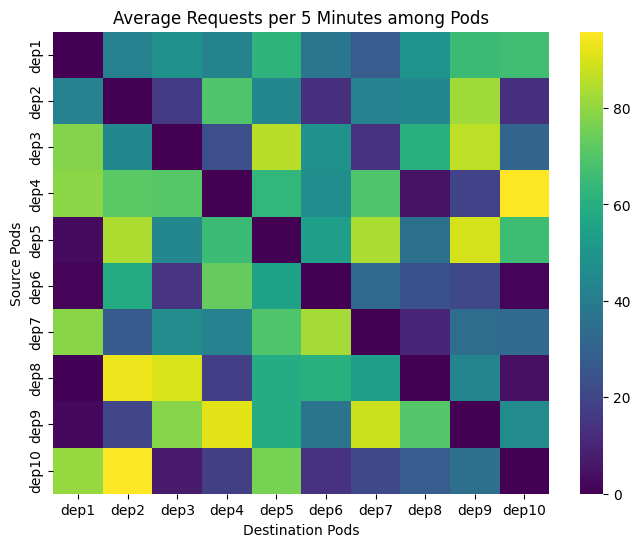

innitial_placement: [3, 8, 0, 2, 0, 4, 1, 4, 5, 7]
initial_cost: 11810.247956499254
Final Placement: [3, 8, 0, 2, 0, 4, 1, 4, 5, 7]
Total Communication Cost: 377927.9346079759


In [8]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import multiprocessing as mp
from timeit import default_timer as timer

def transmitted_req_calculator(workload_src, workload_dst, timerange, step_interval):
    return np.random.rand() * 100

ready_deployments = ['dep1', 'dep2', 'dep3', 'dep4', 'dep5','dep6', 'dep7', 'dep8', 'dep9', 'dep10']

df = pd.DataFrame(index=ready_deployments, columns=ready_deployments, data=0.0)

for deployment_src in ready_deployments:
    for deployment_dst in ready_deployments:
        if deployment_src != deployment_dst:
            average_requests = transmitted_req_calculator(
                workload_src=deployment_src, 
                workload_dst=deployment_dst, 
                timerange=120, 
                step_interval='5m'
            )
            df.at[deployment_src, deployment_dst] = average_requests

plt.figure(figsize=(8,6))
sns.heatmap(df, cmap='viridis', fmt=".2f")
plt.title('Average Requests per 5 Minutes among Pods')
plt.xlabel('Destination Pods')
plt.ylabel('Source Pods')
plt.show()

exec_graph = df.to_numpy()

def calculate_communication_cost(exec_graph, placement, delay_matrix):
    cost = 0
    for u in range(len(exec_graph)):
        for v in range(len(exec_graph[u])):
            if exec_graph[u][v] > 0:
                server_u = placement[u]
                server_v = placement[v]
                cost += exec_graph[u][v] * delay_matrix[server_u][server_v]
    return cost

def greedy_placement_worker(exec_graph, delay_matrix, placement, num_servers, start, end):
    current_cost = calculate_communication_cost(exec_graph, placement, delay_matrix)
    improved = True
    while improved:
        improved = False
        for u in range(start, end):
            current_server = placement[u]
            for new_server in range(num_servers):
                if new_server != current_server:
                    new_placement = placement.copy()
                    new_placement[u] = new_server
                    new_cost = calculate_communication_cost(exec_graph, new_placement, delay_matrix)
                    if new_cost < current_cost:
                        placement[u] = new_server
                        current_cost = new_cost
                        improved = True
                        break
    return current_cost

def parallel_greedy_placement(exec_graph, delay_matrix, placement, num_servers, num_workers=4):
    with mp.Manager() as manager:
        placement = manager.list(placement)
        pool = mp.Pool(num_workers)
        num_microservices = len(exec_graph)
        chunk_size = num_microservices // num_workers
        chunks = [(exec_graph, delay_matrix, placement, num_servers, i*chunk_size, (i+1)*chunk_size) for i in range(num_workers)]
        results = pool.starmap(greedy_placement_worker, chunks)
        pool.close()
        pool.join()

        total_cost = sum(results)
        placement = list(placement)
    
    return placement, total_cost

M = len(exec_graph)
N = 10
delay_matrix = np.random.rand(N, N) * 5

innitial_placement = [random.randint(0, N - 1) for _ in range(M)]
initial_cost = calculate_communication_cost(exec_graph, innitial_placement, delay_matrix)

final_placement, total_cost = parallel_greedy_placement(exec_graph, delay_matrix, innitial_placement, N, num_workers=mp.cpu_count())

print("innitial_placement:", innitial_placement)
print("initial_cost:", initial_cost)
print("Final Placement:", final_placement)
print("Total Communication Cost:", total_cost)

In [28]:
# delay_matrix
df = pd. DataFrame(delay_matrix)
df

,0,1,2,3,4,5,6,7,8,9
0,2.089101,1.744321,3.860245,4.163947,4.144471,4.324999,1.668889,3.896413,0.910566,4.556916
1,4.259610,4.688077,3.510483,1.617654,0.209189,2.071890,2.578318,1.836965,1.073740,0.580055
2,2.129266,1.896541,3.555319,4.820696,4.908990,0.991545,3.981829,0.867176,4.958306,1.747218
3,1.895795,4.121556,2.512684,2.328150,4.082695,1.838296,2.856229,3.883677,1.968858,3.272608
4,0.130808,2.479479,2.271891,2.871571,4.391073,2.057667,1.705680,0.656833,0.124134,2.038341
5,0.091193,0.778874,0.813494,2.744618,2.353040,3.347302,4.671526,4.716363,3.753142,4.781794
6,1.780139,3.597046,0.811486,2.052615,3.445109,3.794159,4.284824,3.553114,1.927647,2.848269
7,4.257339,3.353459,2.104743,2.627619,3.715151,0.457660,2.965565,0.680095,1.484336,0.505089
8,1.692448,1.142916,4.824060,0.775795,2.541302,0.111717,0.765976,0.792266,3.895037,4.800925
9,4.715580,2.846257,0.356819,2.645488,1.012483,0.558583,0.584577,1.458238,3.800975,1.136255


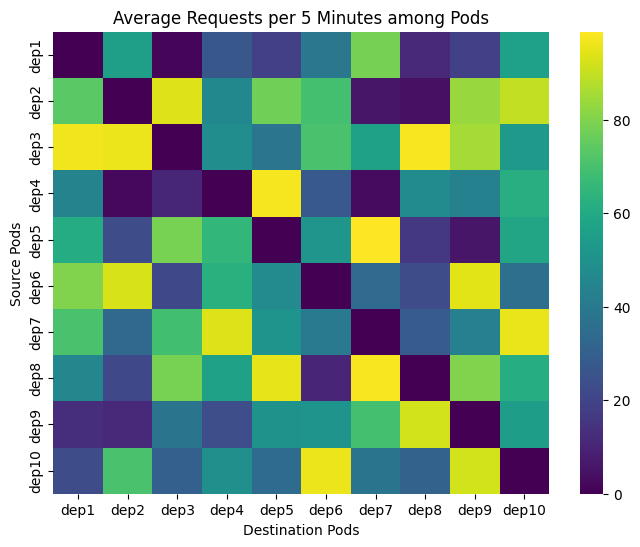

innitial_placement: [1, 6, 8, 5, 0, 5, 0, 9, 9, 4]
initial_cost: 11499.434930779587
Final Placement: [1, 6, 8, 5, 0, 5, 0, 9, 9, 4]
Total Communication Cost: 11499.434930779587


In [23]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import multiprocessing as mp
from timeit import default_timer as timer

# Dummy function for transmitted_req_calculator for demonstration purposes
def transmitted_req_calculator(workload_src, workload_dst, timerange, step_interval):
    # Replace with actual calculation logic
    return np.random.rand() * 100

# Example list of deployments (replace with actual deployment names)
ready_deployments = ['dep1', 'dep2', 'dep3', 'dep4', 'dep5','dep6', 'dep7', 'dep8', 'dep9', 'dep10']

# Initialize an empty DataFrame
df = pd.DataFrame(index=ready_deployments, columns=ready_deployments, data=0.0)

# Fill the DataFrame with average request values
for deployment_src in ready_deployments:
    for deployment_dst in ready_deployments:
        if deployment_src != deployment_dst:  # Skip self to self comparison
            average_requests = transmitted_req_calculator(
                workload_src=deployment_src, 
                workload_dst=deployment_dst, 
                timerange=120, 
                step_interval='5m'
            )
            df.at[deployment_src, deployment_dst] = average_requests

# Plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df, cmap='viridis', fmt=".2f")
plt.title('Average Requests per 5 Minutes among Pods')
plt.xlabel('Destination Pods')
plt.ylabel('Source Pods')
plt.show()

# Convert DataFrame to exec_graph (numpy array)
exec_graph = df.to_numpy()

# Define the functions for placement and cost calculation
def calculate_communication_cost(exec_graph, placement, delay_matrix):
    cost = 0
    for u in range(len(exec_graph)):
        for v in range(len(exec_graph[u])):
            if exec_graph[u][v] > 0:
                server_u = placement[u]
                server_v = placement[v]
                cost += exec_graph[u][v] * delay_matrix[server_u][server_v]
    return cost

def greedy_placement_worker(exec_graph, delay_matrix, placement, num_servers, start, end):
    current_cost = calculate_communication_cost(exec_graph, placement, delay_matrix)
    improved = True
    while improved:
        improved = False
        for u in range(start, end):
            current_server = placement[u]
            for new_server in range(num_servers):
                if new_server != current_server:
                    new_placement = placement.copy()
                    new_placement[u] = new_server
                    new_cost = calculate_communication_cost(exec_graph, new_placement, delay_matrix)
                    if new_cost < current_cost:
                        placement = new_placement
                        current_cost = new_cost
                        improved = True
                        break
    return placement, current_cost

def parallel_greedy_placement(exec_graph, delay_matrix, placement, num_servers, num_workers=4):
    pool = mp.Pool(num_workers)
    num_microservices = len(exec_graph)
    chunk_size = num_microservices // num_workers
    chunks = [(exec_graph, delay_matrix, placement, num_servers, i*chunk_size, (i+1)*chunk_size) for i in range(num_workers)]
    results = pool.starmap(greedy_placement_worker, chunks)
    pool.close()
    pool.join()

    # Combine results from different workers
    for result in results:
        placement, _ = result
    
    return placement, calculate_communication_cost(exec_graph, placement, delay_matrix)

# Example usage with randomly generated delay matrix and initial placement
M = len(exec_graph)  # Number of microservices
N = 10  # Number of servers (adjust as needed)
delay_matrix = np.random.rand(N, N) * 5  # generate delay matrix with random delays between 0 and 5

# Initial random placement
innitial_placement = [random.randint(0, N - 1) for _ in range(M)]
initial_cost = calculate_communication_cost(exec_graph, innitial_placement, delay_matrix)

# Perform parallel greedy placement
final_placement, total_cost = parallel_greedy_placement(exec_graph, delay_matrix, innitial_placement, N, num_workers=mp.cpu_count())

print("innitial_placement:", innitial_placement)
print("initial_cost:", initial_cost)


print("Final Placement:", final_placement)
print("Total Communication Cost:", total_cost)


In [8]:
delay_matrix

array([[2.91606731e-01, 4.97149555e+00, 3.73426386e+00, 1.94869172e+00,
        2.51923749e+00, 1.56571819e+00, 1.35454204e+00, 2.06088456e+00,
        5.91471057e-01, 9.59817863e-01],
       [4.98939771e+00, 2.32492761e+00, 3.27665311e+00, 2.72817859e+00,
        2.21160624e+00, 3.19122158e-01, 3.04416754e+00, 4.08922199e+00,
        4.91742651e+00, 4.23671451e+00],
       [4.43050868e+00, 2.24476218e+00, 2.45046501e+00, 2.33546145e+00,
        4.46505014e+00, 2.63049351e+00, 2.57765185e+00, 8.56461581e-01,
        4.16898801e+00, 4.29970881e-01],
       [2.71079557e+00, 1.17760201e+00, 4.78308848e+00, 3.67837411e+00,
        9.38148241e-01, 3.35813312e+00, 3.77293165e+00, 4.60870109e+00,
        2.45324412e+00, 2.81178045e+00],
       [9.65139073e-02, 1.76447018e+00, 3.10171526e+00, 1.42263627e+00,
        6.71919549e-01, 4.95121782e+00, 1.15445817e+00, 7.35126601e-01,
        2.91074409e-01, 3.75853778e+00],
       [4.46782154e+00, 2.30288450e+00, 3.40095404e+00, 3.96469825e+00,
   

In [6]:
exec_graph

array([[ 0.        , 15.91130295, 11.9855949 , 20.75148535, 92.94287211],
       [68.54341672,  0.        , 45.76872572, 66.65730295, 75.59382368],
       [71.80362139, 32.81535687,  0.        , 58.79806044, 50.52248869],
       [89.80459598, 72.75048612, 50.75105941,  0.        , 98.90522146],
       [19.00573222, 61.71033066, 84.31656999, 23.72933824,  0.        ]])

Microservices: 10, Servers: 1
Initial Placement: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Final Placement: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Initial Cost: 4148.632346794811, Final Cost: 4148.632346794811
Time: 0.2224 seconds

Microservices: 10, Servers: 2
Initial Placement: [0, 0, 0, 1, 1, 1, 0, 0, 1, 1]
Final Placement: [0, 0, 0, 1, 1, 1, 0, 0, 1, 1]
Initial Cost: 5035.2564385815995, Final Cost: 5035.2564385815995
Time: 0.1797 seconds

Microservices: 10, Servers: 3
Initial Placement: [1, 2, 2, 0, 1, 1, 0, 2, 1, 0]
Final Placement: [1, 2, 2, 0, 1, 1, 0, 2, 1, 0]
Initial Cost: 3675.0197932280707, Final Cost: 3675.0197932280707
Time: 0.1941 seconds

Microservices: 10, Servers: 4
Initial Placement: [2, 2, 1, 0, 2, 3, 2, 2, 0, 3]
Final Placement: [2, 2, 1, 0, 2, 3, 2, 2, 0, 3]
Initial Cost: 3537.688147902788, Final Cost: 3537.688147902788
Time: 0.1863 seconds

Microservices: 10, Servers: 5
Initial Placement: [2, 1, 2, 2, 4, 3, 3, 3, 4, 4]
Final Placement: [2, 1, 2, 2, 4, 3, 3, 3, 4, 4]
Initial Cost: 34

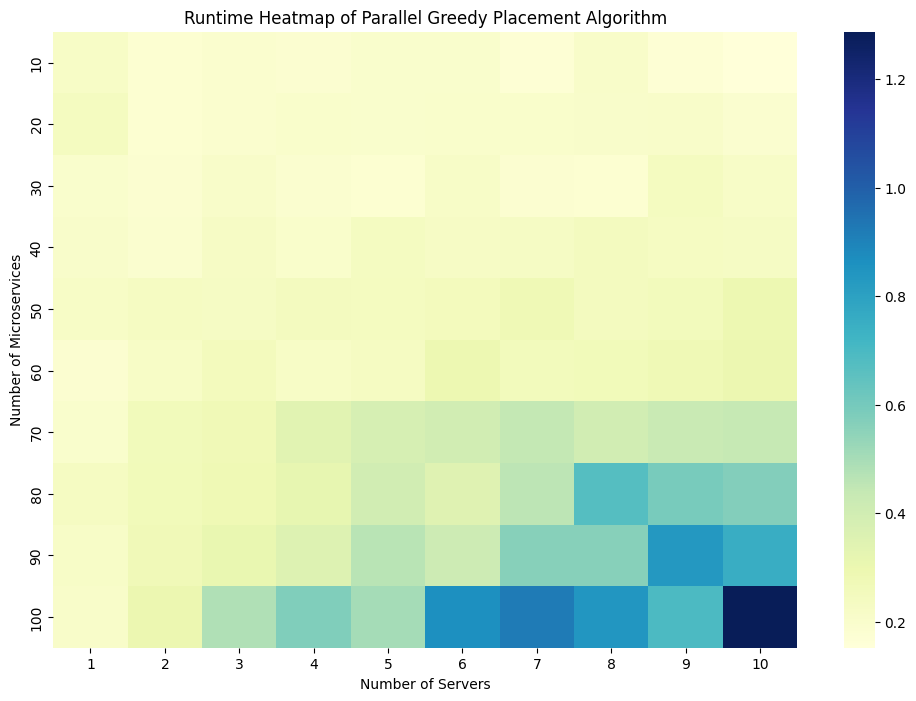

In [1]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer
import multiprocessing as mp

def calculate_communication_cost(exec_graph, placement, delay_matrix):
    cost = 0
    for u in range(len(exec_graph)):
        for v in range(len(exec_graph[u])):
            if exec_graph[u][v] > 0:
                server_u = placement[u]
                server_v = placement[v]
                cost += exec_graph[u][v] * delay_matrix[server_u][server_v] # the cost is calculated by traffic*delay
    return cost

def greedy_placement_worker(exec_graph, delay_matrix, placement, num_servers, start, end):
    current_cost = calculate_communication_cost(exec_graph, placement, delay_matrix)
    improved = True
    while improved:
        improved = False
        for u in range(start, end):
            current_server = placement[u]
            for new_server in range(num_servers):
                if new_server != current_server:
                    new_placement = placement.copy()
                    new_placement[u] = new_server
                    new_cost = calculate_communication_cost(exec_graph, new_placement, delay_matrix)
                    if new_cost < current_cost:
                        placement = new_placement
                        current_cost = new_cost
                        improved = True
                        break
    return placement, current_cost

def parallel_greedy_placement(exec_graph, delay_matrix, placement, num_servers, num_workers=4):
    pool = mp.Pool(num_workers)
    num_microservices = len(exec_graph)
    chunk_size = num_microservices // num_workers # //: divide with integral result (discard remainder)
    chunks = [(exec_graph, delay_matrix, placement, num_servers, i*chunk_size, (i+1)*chunk_size) for i in range(num_workers)]
    results = pool.starmap(greedy_placement_worker, chunks)
    pool.close()
    pool.join()

    # Combine results from different workers
    for result in results:
        placement, _ = result
    
    return placement, calculate_communication_cost(exec_graph, placement, delay_matrix)

def generate_exec_graph(M):
    return np.random.randint(0, 30, size=(M, M))

def generate_delay_matrix(N):
    return np.random.rand(N, N) * 5

def measure_runtime(microservice_range, server_range, num_workers=4):
    runtime_matrix = np.zeros((len(microservice_range), len(server_range)))
    for i, M in enumerate(microservice_range):
        for j, N in enumerate(server_range):
            exec_graph = generate_exec_graph(M)
            delay_matrix = generate_delay_matrix(N)
            initial_placement = [random.randint(0, N - 1) for _ in range(M)]

            start_time = timer()
            final_placement, final_cost = parallel_greedy_placement(exec_graph, delay_matrix, initial_placement.copy(), N, num_workers)
            end_time = timer()
            runtime_matrix[i, j] = end_time - start_time

            initial_cost = calculate_communication_cost(exec_graph, initial_placement, delay_matrix)
            
            print(f"Microservices: {M}, Servers: {N}")
            print(f"Initial Placement: {initial_placement}")
            print(f"Final Placement: {final_placement}")
            print(f"Initial Cost: {initial_cost}, Final Cost: {final_cost}")
            print(f"Time: {end_time - start_time:.4f} seconds\n")

    return runtime_matrix

microservice_range = range(10, 101, 10)
server_range = range(1, 11, 1)

runtime_matrix = measure_runtime(microservice_range, server_range, num_workers=mp.cpu_count())

plt.figure(figsize=(12, 8))
sns.heatmap(runtime_matrix, xticklabels=server_range, yticklabels=microservice_range, cmap="YlGnBu")
plt.xlabel("Number of Servers")
plt.ylabel("Number of Microservices")
plt.title("Runtime Heatmap of Parallel Greedy Placement Algorithm")
plt.show()
